In [18]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from utils import plot_images_full, generate_matrix, batch_dirichlet, get_similarities, plot_similarities, get_differences, plot_differences, get_images, plot_images

#from models.vit import ViT, SimpleViT, SimpleViTI, SimpleViTFT
from models.diffusion import SimpleTransformer
from models.vit import SimpleViT

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
batch_size = 1
device = 'cpu'
data_path = './data/'

In [8]:
train_path = './data/imagewoof2-320/train'
val_path = './data/imagewoof2-320/val'
valc_path = './data/imagewoof2-320/val_c'
size = 256
augment = True

test_transforms_list = [
    transforms.Resize((size, size)),
    transforms.transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

train_transforms_list = [
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]


test_transforms = transforms.transforms.Compose(test_transforms_list)

if augment:
    train_transforms = transforms.transforms.Compose(train_transforms_list)
else:
    train_transforms = test_transforms

trainset = ImageFolder(
    root=train_path, 
    transform=train_transforms
)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

valset = ImageFolder(
    root=val_path, 
    transform=train_transforms
)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

valcset = ImageFolder(
    root=valc_path, 
    transform=train_transforms
)
valc_loader = torch.utils.data.DataLoader(valcset, batch_size=batch_size,shuffle=False, num_workers=4)

criterion = torch.nn.CrossEntropyLoss()

In [9]:
def eval_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = val_acc = 0.0
    for (img, labels) in val_loader:
        img, labels = img.to(device), labels.to(device)
        with torch.no_grad():
            predictions = model(img)
            loss = criterion(predictions, labels)
            correct = torch.argmax(predictions.data, 1) == labels
        val_loss += loss
        val_acc += correct.sum()
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
        
    print(f" Test acc {val_acc:.3f}, Test loss {val_loss:.6f}")

In [14]:
depth=64
def get_model(m,s,wn,t,ws,acc,load=True):
    model = SimpleViT(
        image_size = 256,
        patch_size = 32,
        num_classes = 10,
        dim = 1024,
        depth = 32,
        heads = 16,
        dropout = 0.2,
        method = m,
        tau=t,
        weight_norm = wn
    )
    if load: model.load_state_dict(torch.load(f"model_method_{m}_sign_{s}_tau_{t}_wn_{wn}_ws_{ws}_acc_{acc}.pth"))
    return model

In [15]:
image = trainset[10][0].to(device).unsqueeze(0)

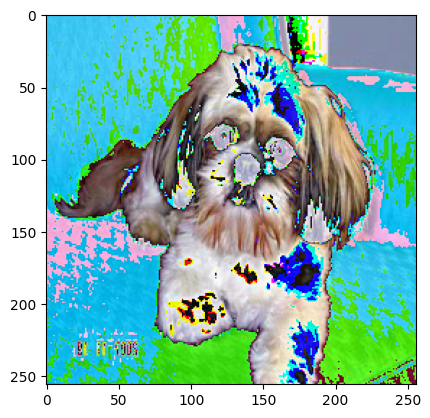

In [16]:
plt.imshow(transforms.ToPILImage()(((image+1)/2).squeeze(0)))

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [43]:
model = get_model(m='PMK',s=0,wn=False,t=1,ws=False,acc=42,load=True).to(device)

RuntimeError: Error(s) in loading state_dict for SimpleViT:
	Missing key(s) in state_dict: "transformer.K1", "transformer.K2". 
	Unexpected key(s) in state_dict: "transformer.K". 

In [28]:
#model.attn_norm = True
#model.weight_norm = True

In [29]:
outputs = [model.ll_diffuse(image)]

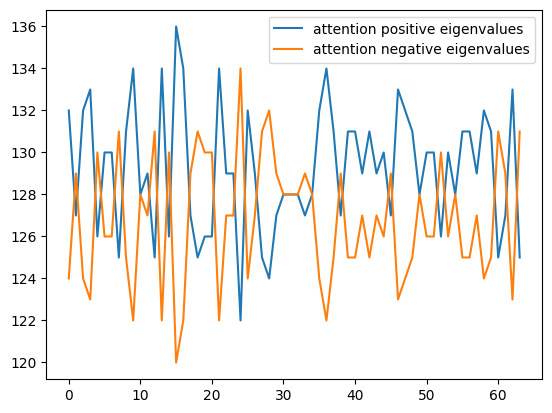

In [265]:
poseigs,negeigs=[],[]
for A in attentions:
    cpos,cneg=0,0
    for eig in np.linalg.eig(A[0,...])[0]:
        if eig>=0:
            cpos+=1
        else:
            cneg+=1
    poseigs.append(cpos)
    negeigs.append(cneg)
    
plt.plot(poseigs,label="attention positive eigenvalues")
plt.plot(negeigs,label="attention negative eigenvalues")
plt.legend()
plt.show()

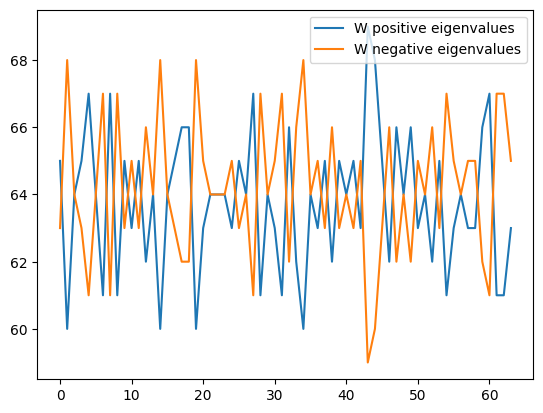

In [266]:
poseigs,negeigs=[],[]
for W in Ws:
    cpos,cneg=0,0
    for eig in np.linalg.eig(W.cpu().detach().numpy())[0]:
        if eig>=0:
            cpos+=1
        else:
            cneg+=1
    poseigs.append(cpos)
    negeigs.append(cneg)
    
plt.plot(poseigs,label="W positive eigenvalues")
plt.plot(negeigs,label="W negative eigenvalues")
plt.legend()
plt.show()

In [267]:
# idx=0
# one=torch.kron(Ws[idx],torch.from_numpy(attentions[idx][0,...]).to(device))
# Q=one+torch.eye(one.size(-1))
# is_pos_def((Q.T@Q-torch.eye(Q.size(-1))).cpu().detach().numpy())

In [268]:
# is_pos_def((Q.T@Q-torch.eye(Q.size(-1))).cpu().detach().numpy())

In [30]:
dirichlet_input = [x/(np.linalg.norm(x, ord='fro', axis=(-1,-2))) for x in outputs]
#dirichlet_input = [x for x in outputs]
similarities = get_similarities(dirichlet_input)
#plot_similarities(similarities[10:])

In [31]:
similarities

[23.48974592846965]

In [42]:
model.transformer.K2

Parameter containing:
tensor([1.0069], requires_grad=True)

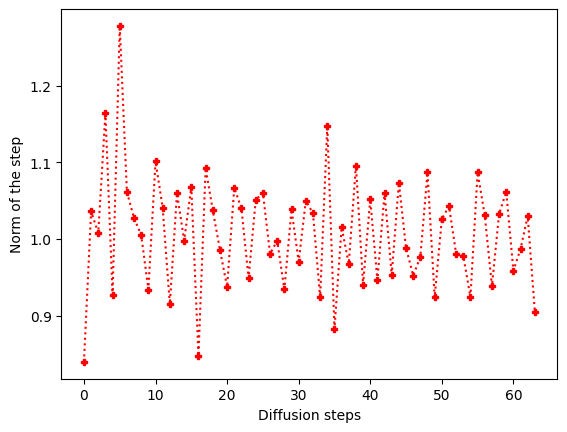

In [271]:
differences = get_differences(outputs)
plot_differences(differences)

In [272]:
differences[-1]

0.9051499585322627

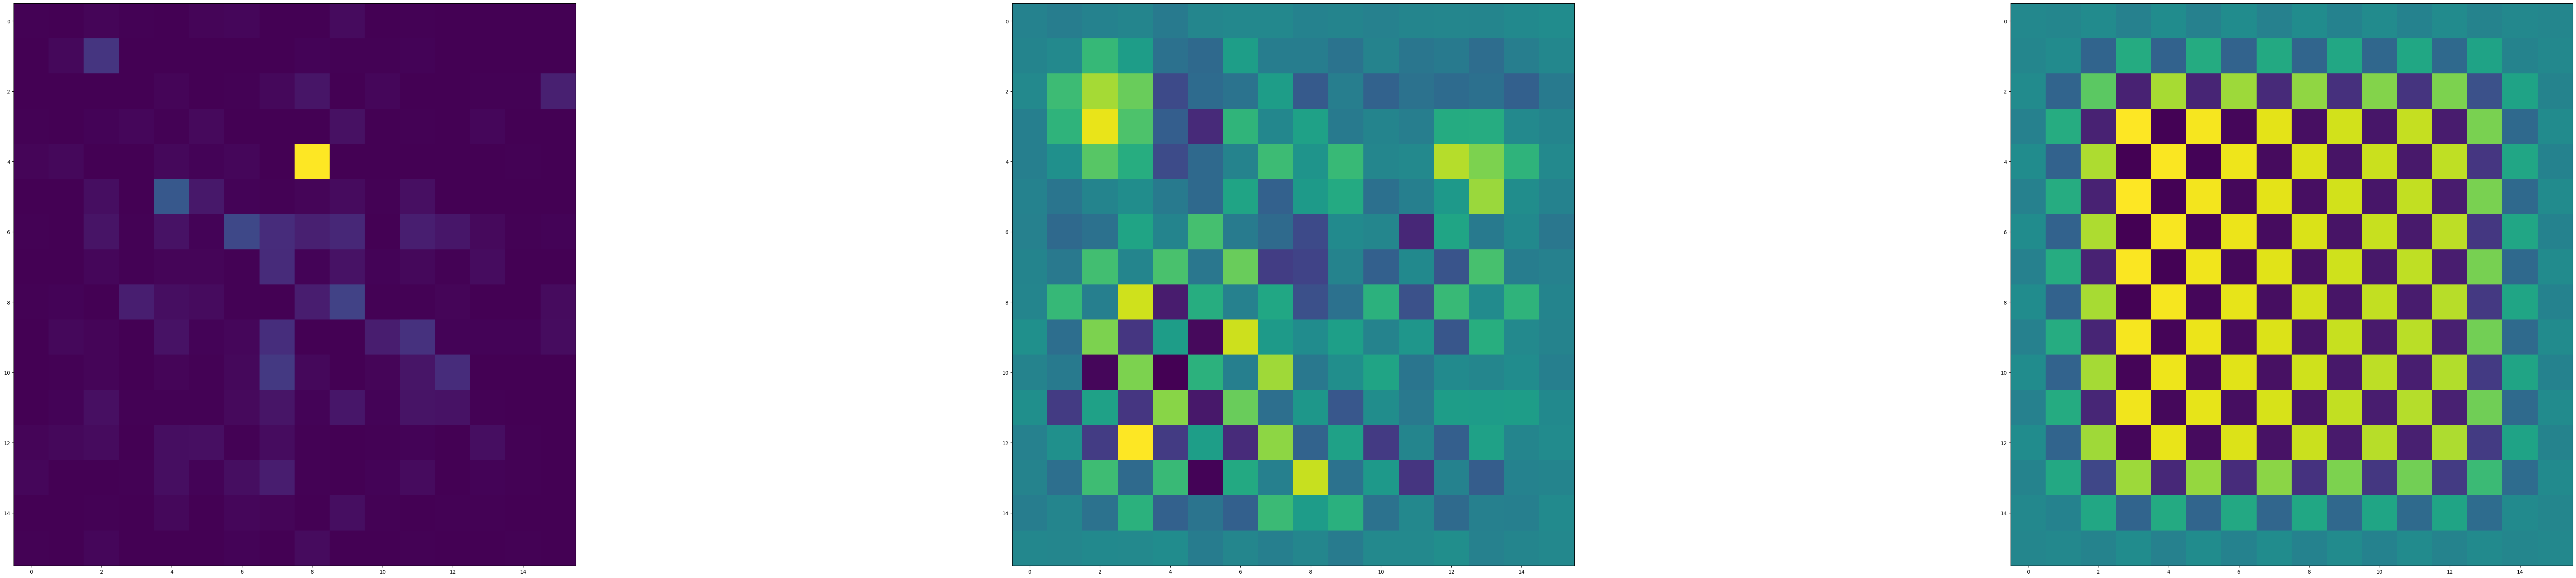

In [275]:
plot_images_full([attentions[0][0,0].reshape(1,16,16),attentions[15][0,0].reshape(1,16,16),attentions[-1][0,0].reshape(1,16,16)])

In [259]:
eval_model(model, val_loader, criterion, device)

KeyboardInterrupt: 

In [ ]:
model.depth = 32
model.tau = 0.5

In [ ]:
eval_model(model, val_loader, criterion, device)

In [ ]:
model.depth = 32
model.tau = (depth*model.tau)/model.depth
model.tau

In [ ]:
eval_model(model, val_loader, criterion, device)